# Logistic Regression Model

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score

import numpy as np

In [2]:
loan = pd.read_csv('cr_loan_clean.csv')
loan.head()

,Unnamed: 0,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
1,2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
2,3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
3,4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
4,5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2


Now that I have cleanes the data I will focus on modeling. The first model I will try is simple logistic regression.

I will try to predict the probability of default, which is the probability that someone will default on a loan based on some characteristics about the person.

## Prepare non-numeric Data

In [10]:
loan.dtypes

Unnamed: 0                      int64
person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object

In [11]:
# Create two data sets for numeric and non-numeric data
cred_num = loan.select_dtypes(exclude=['object'])
cred_str = loan.select_dtypes(include=['object'])

In [13]:
# One-hot encode the non-numeric columns
cred_str_onehot = pd.get_dummies(cred_str)

# Union the one-hot encoded columns to the numeric ones
cr_loan_prep = pd.concat([cred_num, cred_str_onehot], axis=1)

# Print the columns in the new data set
cr_loan_prep.head()

,Unnamed: 0,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
0,1,21,9600,5.0,1000,11.14,0,0.10,2,0,...,0,0,1,0,0,0,0,0,1,0
1,2,25,9600,1.0,5500,12.87,1,0.57,3,1,...,0,0,0,1,0,0,0,0,1,0
2,3,23,65500,4.0,35000,15.23,1,0.53,2,0,...,0,0,0,1,0,0,0,0,1,0
3,4,24,54400,8.0,35000,14.27,1,0.55,4,0,...,0,0,0,1,0,0,0,0,0,1
4,5,21,9900,2.0,2500,7.14,1,0.25,2,0,...,1,1,0,0,0,0,0,0,1,0


# Split Data

In [17]:
# Split data
X = cr_loan_prep.drop(['loan_status'], axis=1)
y = cr_loan_prep.loan_status

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)

In [31]:
# Train the logistic regression model on the training data
clf_logistic = LogisticRegression(solver='lbfgs').fit(X_train, np.ravel(y_train))

# Create predictions of probability for loan status using test data
preds = clf_logistic.predict_proba(X_test)

# Create a dataframe for the probabilities of default
preds_df = pd.DataFrame(preds[:,1], columns = ['prob_default'])

preds_df.head()

,prob_default
0,0.055394
1,0.201148
2,0.113168
3,0.290167
4,0.550857


In [32]:

# Reassign loan status based on the threshold
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)

# Print the row counts for each loan status
print(preds_df['loan_status'].value_counts())

# Print the classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df['loan_status'], target_names=target_names))

0    10440
1     1346
Name: loan_status, dtype: int64
              precision    recall  f1-score   support

 Non-Default       0.84      0.95      0.89      9177
     Default       0.68      0.35      0.46      2609

    accuracy                           0.82     11786
   macro avg       0.76      0.65      0.68     11786
weighted avg       0.80      0.82      0.80     11786



Accuracy is: 0.8191922620057696


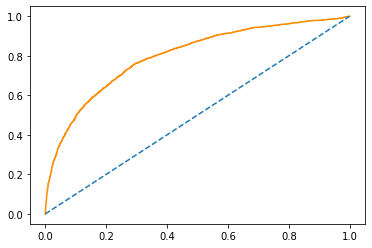

In [33]:
# Create predictions and store them in a variable
preds = clf_logistic.predict_proba(X_test)

# Print the accuracy score the model
print(f"Accuracy is: {clf_logistic.score(X_test, y_test)}")

# Plot the ROC curve of the probabilities of default
prob_default = preds[:, 1]
fallout, sensitivity, thresholds = roc_curve(y_test, prob_default)
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

# Compute the AUC and store it in a variable
auc = roc_auc_score(y_test, prob_default)

# Threshold selection

In [36]:
thresh = [0.2,
 0.225,
 0.25,
 0.275,
 0.3,
 0.325,
 0.35,
 0.375,
 0.4,
 0.425,
 0.45,
 0.475,
 0.5,
 0.525,
 0.55,
 0.575,
 0.6,
 0.625,
 0.65]

def_recalls = [0.7981438515081206,
 0.7583139984532096,
 0.7157772621809745,
 0.6759474091260634,
 0.6349574632637278,
 0.594354215003867,
 0.5467904098994586,
 0.5054137664346481,
 0.46403712296983757,
 0.39984532095901004,
 0.32211910286156226,
 0.2354988399071926,
 0.16782675947409126,
 0.1148491879350348,
 0.07733952049497293,
 0.05529775715390565,
 0.03750966744006187,
 0.026295436968290797,
 0.017788089713843776]

nondef_recalls = [0.5342465753424658,
 0.5973037616873234,
 0.6552511415525114,
 0.708306153511633,
 0.756468797564688,
 0.8052837573385518,
 0.8482278756251359,
 0.8864970645792564,
 0.9215046749293324,
 0.9492280930637095,
 0.9646662317895195,
 0.9733637747336378,
 0.9809741248097412,
 0.9857577734290063,
 0.9902152641878669,
 0.992280930637095,
 0.9948901935203305,
 0.9966297021091541,
 0.997499456403566]

accs = [0.5921588594704684,
 0.6326374745417516,
 0.6685336048879837,
 0.7012050237610319,
 0.7298031228784793,
 0.7589952477936185,
 0.7820773930753564,
 0.8028682959945689,
 0.8211133740665308,
 0.8286659877800407,
 0.8236591989137814,
 0.811439239646979,
 0.8025288526816021,
 0.7946367956551256,
 0.7898845892735913,
 0.7866598778004074,
 0.7847929395790902,
 0.7836897488119484,
 0.7825016972165648]

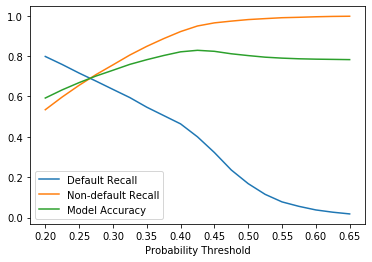

In [39]:
plt.plot(thresh,def_recalls)
plt.plot(thresh,nondef_recalls)
plt.plot(thresh, accs)
plt.xlabel("Probability Threshold")
plt.xticks([0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65])
plt.legend(["Default Recall","Non-default Recall","Model Accuracy"])
plt.show()

The best threshold seems to be 0.275

In [40]:
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.275 else 0)

# Print the classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df['loan_status'], target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.90      0.76      0.82      9177
     Default       0.45      0.69      0.55      2609

    accuracy                           0.75     11786
   macro avg       0.67      0.73      0.69     11786
weighted avg       0.80      0.75      0.76     11786

